In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout

In [4]:
data_dir =r"E:\1. Thesis\PDD_MangoLeaf\Dataset"
keyword= ['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [5]:
class_folders=os.listdir(data_dir)
image_paths=[]
labels=[]

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
                class_path=os.path.join(data_dir,class_folder)
                image_files=os.listdir(class_path)
                for image_file in image_files:
                    image_path=os.path.join(class_path,image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    
df=pd.DataFrame({'image_path':image_paths,'label':labels})
print("The classes:n",np.unique(df['label']))

The classes:n ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


Data Visualization

In [15]:
print(df['label'].unique())
class_counts=df['label'].value_counts()
class_counts

['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


label
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64

#### Modified BatchSize=32, split=60%+20%+20%, targetSize=(224,224,3), lr=.00001

In [21]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

Dataset Preprocess

In [22]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224,224)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224,224))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


MobileNetV2

In [23]:
num_classes=8
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable=True
inputs=base_model.input
#inputs = tf.keras.Input(shape=(128,128,3)) #Define input
x = base_model(inputs,training=True)     #pass input to base model
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)  #Create model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,577,928 (13.65 MB)

 Trainable params: 3,543,816 (13.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [25]:
epochs=10
history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)
   

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 604s 7s/step - accuracy: 0.3529 - loss: 1.8607 - val_accuracy: 0.3625 - val_loss: 1.7200
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 490s 6s/step - accuracy: 0.8743 - loss: 0.8681 - val_accuracy: 0.5738 - val_loss: 1.3297
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 466s 6s/step - accuracy: 0.9472 - loss: 0.4422 - val_accuracy: 0.6425 - val_loss: 1.1038
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 493s 7s/step - accuracy: 0.9643 - loss: 0.2455 - val_accuracy: 0.7038 - val_loss: 0.9279
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 501s 7s/step - accuracy: 0.9795 - loss: 0.1677 - val_accuracy: 0.7487 - val_loss: 0.8104
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 490s 7s/step - accuracy: 0.9834 - loss: 0.1168 - val_accuracy: 0.7775 - val_loss: 0.7157
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 477s 6s/step - accuracy: 0.9886 - loss: 0.0928 - val_accuracy: 0.8087 - val_loss: 0.6293
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 510s 7s/step - accuracy: 0.9900 - loss: 0.0677 - val_accuracy: 0.8338 - v

In [26]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8731 - loss: 0.4529
Test Loss: 0.4304693937301636, Test Accuracy: 0.8799999952316284


In [27]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 979ms/step
                  precision    recall  f1-score   support

     Anthracnose       0.96      0.79      0.87       117
Bacterial Canker       1.00      0.66      0.80       109
  Cutting Weevil       0.99      1.00      1.00       104
        Die Back       0.92      0.99      0.96        97
      Gall Midge       0.69      0.93      0.79       107
         Healthy       0.73      1.00      0.85        77
  Powdery Mildew       0.97      0.89      0.93        98
     Sooty Mould       0.90      0.84      0.87        91

        accuracy                           0.88       800
       macro avg       0.90      0.89      0.88       800
    weighted avg       0.90      0.88      0.88       800



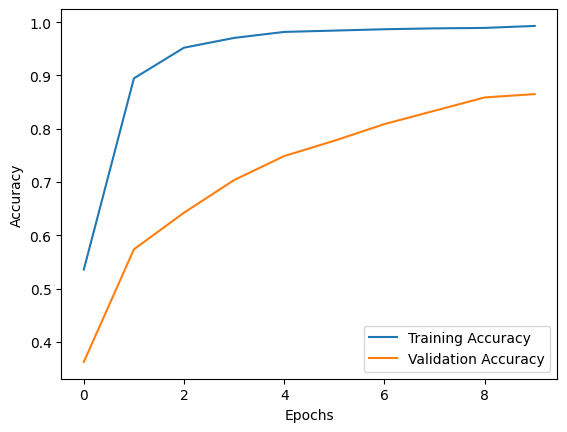

In [28]:
#plot training and validation accuracy
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

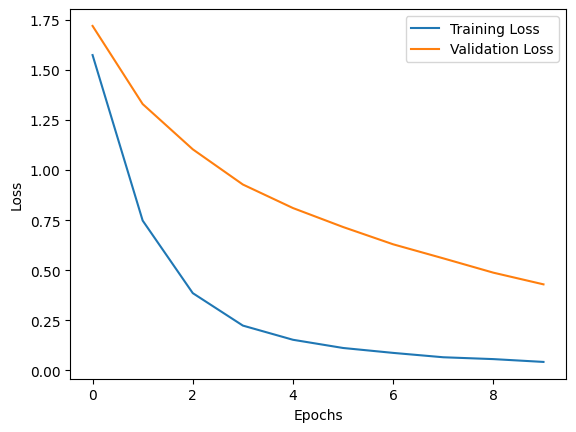

In [29]:
#plot training and validation loss
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
test_predictions=model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 967ms/step


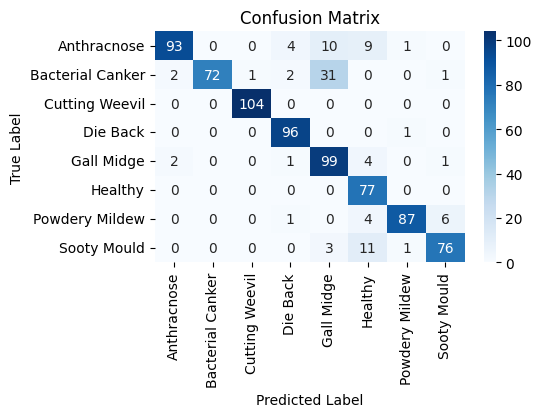

In [31]:
plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Modified BatchSize=32, split=60%+20%+20%, targetSize=128,128, lr=.00001

In [124]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [125]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(128,128)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

In [126]:
train_generator,validation_generator,test_generator=load_images_for_cnn(train_df, val_df, test_df, batch_size=16, target_size=(128,128))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [127]:
num_classes=8
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable=True
inputs=base_model.input
#inputs = tf.keras.Input(shape=(128,128,3)) #Define input
x = base_model(inputs,training=True)     #pass input to base model
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)  #Create model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [128]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_27          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,577,928 (13.65 MB)

 Trainable params: 3,543,816 (13.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [129]:
epochs=10
history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.3419 - loss: 1.8673 - val_accuracy: 0.4750 - val_loss: 1.4510
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 148s 986ms/step - accuracy: 0.8357 - loss: 0.7767 - val_accuracy: 0.6225 - val_loss: 1.0577
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 147s 979ms/step - accuracy: 0.9190 - loss: 0.3999 - val_accuracy: 0.7362 - val_loss: 0.7834
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 147s 980ms/step - accuracy: 0.9371 - loss: 0.2830 - val_accuracy: 0.7925 - val_loss: 0.6175
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9511 - loss: 0.2072 - val_accuracy: 0.8188 - val_loss: 0.4923
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9626 - loss: 0.1657 - val_accuracy: 0.8363 - val_loss: 0.4117
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 191s 991ms/step - accuracy: 0.9568 - loss: 0.1497 - val_accuracy: 0.8650 - val_loss: 0.3236
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9756 - loss: 0.101

In [130]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.9504 - loss: 0.1674
Test Loss: 0.15215367078781128, Test Accuracy: 0.9549999833106995


In [131]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step
                  precision    recall  f1-score   support

     Anthracnose       1.00      0.94      0.97       117
Bacterial Canker       0.97      0.97      0.97       109
  Cutting Weevil       0.99      1.00      1.00       104
        Die Back       0.96      1.00      0.98        97
      Gall Midge       0.96      0.93      0.95       107
         Healthy       0.88      1.00      0.93        77
  Powdery Mildew       0.88      0.99      0.93        98
     Sooty Mould       1.00      0.80      0.89        91

        accuracy                           0.95       800
       macro avg       0.96      0.95      0.95       800
    weighted avg       0.96      0.95      0.95       800



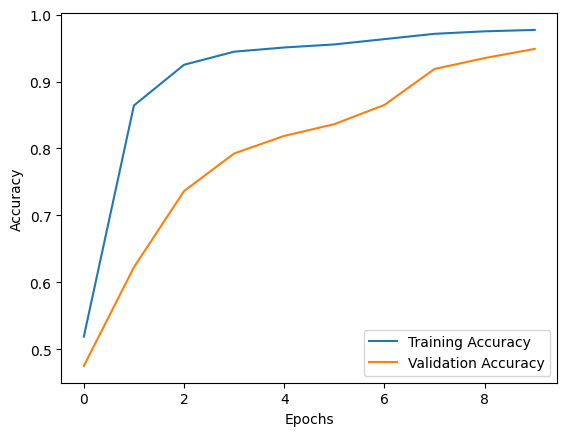

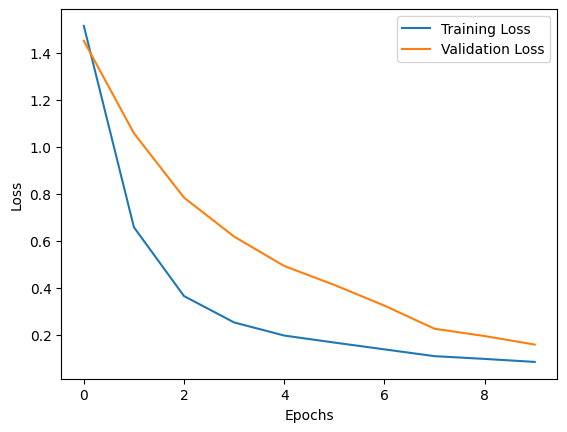

In [132]:
#plot training and validation accuracy
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plot training and validation loss
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [133]:
test_predictions=model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step


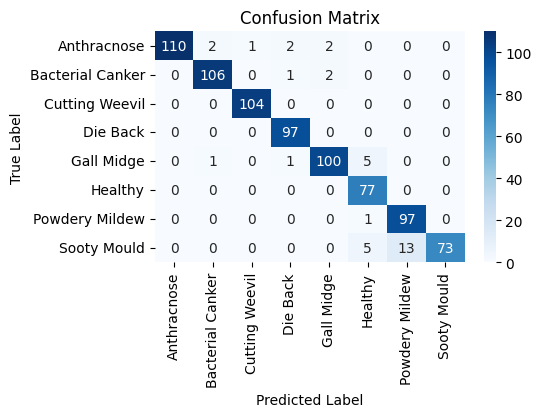

In [134]:
plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [135]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)

In [136]:
model.name="MangoLeaf_MobileNetV2"
model.save('MobileNetV2.keras')